In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.callbacks import Callback, EarlyStopping
from keras.utils.np_utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_raw = pickle.load(open('./feat_descrip.pickle','r'))
test_raw = pickle.load(open('./feat_descrip_TEST.pickle','r'))
label = pickle.load(open('./label_variety.pickle','r'))
label_ts = pickle.load(open('./label_variety_TEST.pickle','r'))

In [3]:
vocab_size = train_raw.shape[1]
n_class = max(label) + 1

In [4]:
train_feat = train_raw.toarray()
train_label = to_categorical(label, n_class)
val_feat = test_raw.toarray()
val_label = to_categorical(label_ts, n_class)

In [5]:
model = Sequential()
model.add(Dense(512, input_dim=vocab_size))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.75))
model.add(Dense(n_class, activation='softmax'))

def top_3_categorical_accuracy(x, y, k=3):
    return top_k_categorical_accuracy(x, y, k=3)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_3_categorical_accuracy, top_k_categorical_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               10265600  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 560)               287280    
Total params: 10,554,928
Trainable params: 10,553,904
Non-trainable params: 1,024
_________________________________________________________________


In [6]:
class History(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.top1_acc, self.top3_acc, self.top5_acc = [], [], []
        self.val_losses = []
        self.val_top1_acc, self.val_top3_acc, self.val_top5_acc = [], [], []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.top1_acc.append(logs.get('categorical_accuracy'))
        self.top3_acc.append(logs.get('top_3_categorical_accuracy'))
        self.top5_acc.append(logs.get('top_k_categorical_accuracy'))

    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_top1_acc.append(logs.get('val_categorical_accuracy'))
        self.val_top3_acc.append(logs.get('val_top_3_categorical_accuracy'))
        self.val_top5_acc.append(logs.get('val_top_k_categorical_accuracy'))

history = History()
earlystop = EarlyStopping()

In [7]:
model.fit(train_feat, train_label, 
          batch_size=128, 
          epochs=5, 
          shuffle=True, 
          callbacks=[history, earlystop],
          validation_data=(val_feat, val_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 18s 369us/step - loss: 2.9448 - categorical_accuracy: 0.3982 - top_3_categorical_accuracy: 0.5835 - top_k_categorical_accuracy: 0.6571 - val_loss: 3.7444 - val_categorical_accuracy: 0.5442 - val_top_3_categorical_accuracy: 0.7322 - val_top_k_categorical_accuracy: 0.8020
Epoch 2/5
50000/50000 [==============================] - 11s 218us/step - loss: 1.8352 - categorical_accuracy: 0.5877 - top_3_categorical_accuracy: 0.7641 - top_k_categorical_accuracy: 0.8235 - val_loss: 1.8328 - val_categorical_accuracy: 0.5776 - val_top_3_categorical_accuracy: 0.7575 - val_top_k_categorical_accuracy: 0.8268
Epoch 3/5
50000/50000 [==============================] - 11s 224us/step - loss: 1.3969 - categorical_accuracy: 0.6759 - top_3_categorical_accuracy: 0.8309 - top_k_categorical_accuracy: 0.8803 - val_loss: 1.7769 - val_categorical_accuracy: 0.5901 - val_top_3_categorical_accuracy: 0.7671 - val_t

In [8]:
model.evaluate(val_feat, val_label)

10000/10000 [==============================] - 3s 266us/step


[1.787149337387085,
 0.59570000000000001,
 0.76949999999999996,
 0.83599999999999997]

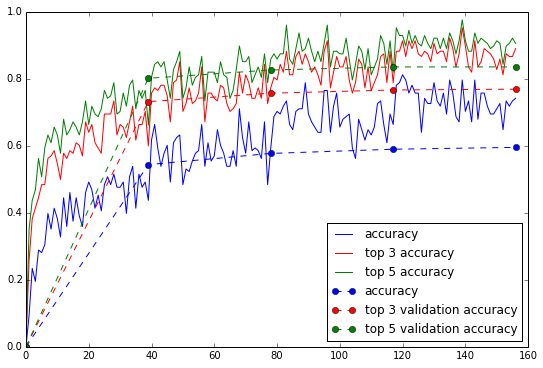

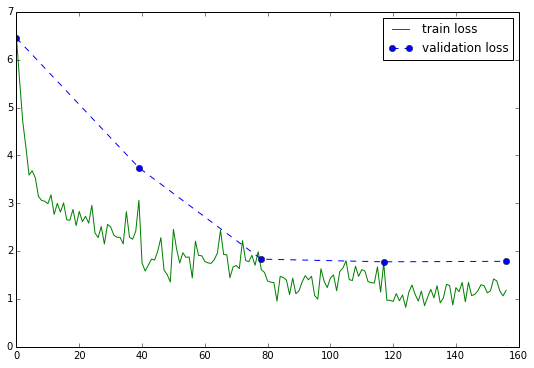

In [11]:
plt.figure(figsize=(9, 6))
n_batch, n_epoch = len(history.top1_acc), len(history.val_top1_acc)
step = 10
# plt.title('Accuracy v.s. number of batches for training and validation set')
plt.plot(history.top1_acc[::step], 'b', label='accuracy')
plt.plot(history.top3_acc[::step], 'r', label='top 3 accuracy')
plt.plot(history.top5_acc[::step], 'g', label='top 5 accuracy')
plt.plot(np.linspace(0, n_batch / step, n_epoch + 1), [0] + history.val_top1_acc, 'b--o', label='accuracy')
plt.plot(np.linspace(0, n_batch / step, n_epoch + 1), [0] + history.val_top3_acc, 'r--o', label='top 3 validation accuracy')
plt.plot(np.linspace(0, n_batch / step, n_epoch + 1), [0] + history.val_top5_acc, 'g--o', label='top 5 validation accuracy')
plt.legend(loc=4)

plt.figure(figsize=(9, 6))
# plt.title('Loss v.s. number of batches for training and validation set')
plt.plot(history.losses[::step], 'g', label='train loss')
plt.plot(np.linspace(0, n_batch / step, n_epoch + 1), [history.losses[0]] + history.val_losses, 'b--o', label='validation loss')
plt.legend()

In [16]:
feat_layer = model.layers[2]
feat_out = feat_layer.output
feat_model = Model(input=model.input, output=feat_out)
train_feat_nn = feat_model.predict(train_feat)
val_feat_nn = feat_model.predict(val_feat)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("de...)`
  app.launch_new_instance()


In [17]:
feat_nn = {'train': train_feat_nn, 'val': val_feat_nn}
pickle.dump(feat_nn, open('feat_nn.pkl', 'wb'))

In [19]:
val_pred = model.predict_classes(val_feat)

In [47]:
from collections import Counter

total = Counter(label_ts)
main_class = filter(lambda k: total[k] > 0, total.keys())
dic = {k: i for i, k in enumerate(main_class)}
m = len(main_class)
confusion = np.zeros((m, m))
for actual, pred in zip(label_ts, val_pred):
    if actual in dic and pred in dic:
        confusion[dic[actual], dic[pred]] += 1

In [48]:
confusion = confusion / np.sum(confusion, axis=1, keepdims=True)
class_acc = np.diag(confusion)

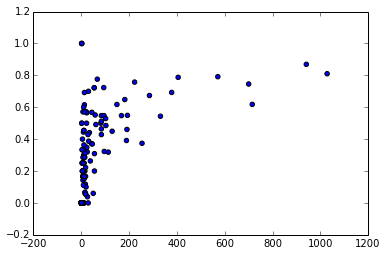

In [49]:
plt.scatter([total[c] for c in main_class], class_acc)